In [33]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models, optimizers, regularizers
from sklearn.utils import class_weight
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import regularizers, Model, optimizers
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [6]:
# this is for hyper tuning (if i do it lol)
import keras_tuner as kt

## Load Data

In [7]:
'''
i took this from the sample data notebook on kaggle
'''
# 2. Load Data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Add .jpg extension to md5hash column to reference the file_name
train_df['md5hash'] = train_df['md5hash'].astype(str) + '.jpg'
test_df['md5hash'] = test_df['md5hash'].astype(str) + '.jpg'

# Combine label and md5hash to form the correct path
train_df['file_path'] = train_df['label'] + '/' + train_df['md5hash']


## Clean/check data

In [8]:
# check the cols, we see qc has a lot of nan
# we will ahve to address this 
train_df.head()

,md5hash,fitzpatrick_scale,fitzpatrick_centaur,label,nine_partition_label,three_partition_label,qc,ddi_scale,file_path
0,fd06d13de341cc75ad679916c5d7e6a6.jpg,4,4,prurigo-nodularis,benign-epidermal,benign,NaN,34,prurigo-nodularis/fd06d13de341cc75ad679916c5d7...
1,a4bb4e5206c4e89a303f470576fc5253.jpg,1,1,basal-cell-carcinoma-morpheiform,malignant-epidermal,malignant,NaN,12,basal-cell-carcinoma-morpheiform/a4bb4e5206c4e...
2,c94ce27e389f96bda998e7c3fa5c4a2e.jpg,5,5,keloid,inflammatory,non-neoplastic,1 Diagnostic,56,keloid/c94ce27e389f96bda998e7c3fa5c4a2e.jpg
3,ebcf2b50dd943c700d4e2b586fcd4425.jpg,3,3,basal-cell-carcinoma,malignant-epidermal,malignant,NaN,34,basal-cell-carcinoma/ebcf2b50dd943c700d4e2b586...
4,c77d6c895f05fea73a8f3704307036c0.jpg,1,1,prurigo-nodularis,benign-epidermal,benign,NaN,12,prurigo-nodularis/c77d6c895f05fea73a8f37043070...


In [11]:
# this is for debugging purposes
train_df.isna().sum()

md5hash                     0
fitzpatrick_scale           0
fitzpatrick_centaur         0
label                       0
nine_partition_label        0
three_partition_label       0
qc                       2770
ddi_scale                   0
file_path                   0
dtype: int64

In [13]:
# let's check whats goin on in qc
train_df['qc'].unique()
# we dont need qrongly labeled data so let's remove

array([nan, '1 Diagnostic', '3 Wrongly labelled', '5 Potentially',
       '4 Other', '2 Characteristic'], dtype=object)

In [14]:
# remove rows where QC is wrong label; drop the qc column afterward
train_df = train_df[train_df["qc"] != "3 Wrongly labelled"].copy()

train_df = train_df.drop(columns=["qc"])

print("Unique labels AFTER QC filtering:", train_df["label"].nunique())


Unique labels AFTER QC filtering: 21


In [19]:
print("DataFrame Info:")
train_df.info()


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 2856 entries, 0 to 2859
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   md5hash                2856 non-null   object
 1   fitzpatrick_scale      2856 non-null   int64 
 2   fitzpatrick_centaur    2856 non-null   int64 
 3   label                  2856 non-null   object
 4   nine_partition_label   2856 non-null   object
 5   three_partition_label  2856 non-null   object
 6   ddi_scale              2856 non-null   int64 
 7   file_path              2856 non-null   object
 8   encoded_label          2856 non-null   object
dtypes: int64(3), object(6)
memory usage: 223.1+ KB


In [22]:
print("DataFrame Describe (Numeric Columns):")
display(train_df.describe())


DataFrame Describe (Numeric Columns):


,fitzpatrick_scale,fitzpatrick_centaur,ddi_scale
count,2856.000000,2856.000000,2856.00000
mean,2.522409,2.093137,23.52521
std,1.473237,1.509251,15.51489
min,-1.000000,-1.000000,-1.00000
25%,2.000000,1.000000,12.00000
50%,2.000000,2.000000,12.00000
75%,3.000000,3.000000,34.00000
max,6.000000,6.000000,56.00000


In [25]:
# show categorical columns
train_df.select_dtypes(exclude=["number","bool_",])

,md5hash,label,nine_partition_label,three_partition_label,file_path,encoded_label
0,fd06d13de341cc75ad679916c5d7e6a6.jpg,prurigo-nodularis,benign-epidermal,benign,prurigo-nodularis/fd06d13de341cc75ad679916c5d7...,16
1,a4bb4e5206c4e89a303f470576fc5253.jpg,basal-cell-carcinoma-morpheiform,malignant-epidermal,malignant,basal-cell-carcinoma-morpheiform/a4bb4e5206c4e...,4
2,c94ce27e389f96bda998e7c3fa5c4a2e.jpg,keloid,inflammatory,non-neoplastic,keloid/c94ce27e389f96bda998e7c3fa5c4a2e.jpg,12
3,ebcf2b50dd943c700d4e2b586fcd4425.jpg,basal-cell-carcinoma,malignant-epidermal,malignant,basal-cell-carcinoma/ebcf2b50dd943c700d4e2b586...,3
4,c77d6c895f05fea73a8f3704307036c0.jpg,prurigo-nodularis,benign-epidermal,benign,prurigo-nodularis/c77d6c895f05fea73a8f37043070...,16
...,...,...,...,...,...,...
2855,aa4f94e33bbc118e2a95f7a8ad0344a1.jpg,folliculitis,inflammatory,non-neoplastic,folliculitis/aa4f94e33bbc118e2a95f7a8ad0344a1.jpg,10
2856,fb1feb5dbf0038eee9348a3740cef6f9.jpg,superficial-spreading-melanoma-ssm,malignant-melanoma,malignant,superficial-spreading-melanoma-ssm/fb1feb5dbf0...,20
2857,811f74634ec6dd7022aa04e4968fea38.jpg,acne,inflammatory,non-neoplastic,acne/811f74634ec6dd7022aa04e4968fea38.jpg,0
2858,9983c4ae2e5b505b746da35d068d00ec.jpg,eczema,inflammatory,non-neoplastic,eczema/9983c4ae2e5b505b746da35d068d00ec.jpg,8


In [21]:
# If 'md5hash' or some ID column is unique, check if any duplicates exist:
duplicate_count = train_df.duplicated(subset=["md5hash"]).sum()
print(f"Number of duplicate md5hash rows: {duplicate_count}")


Number of duplicate md5hash rows: 0


In [23]:
# check again lol
missing_values = train_df.isnull().sum()
print("\nMissing values per column:")
print(missing_values)


Missing values per column:
md5hash                  0
fitzpatrick_scale        0
fitzpatrick_centaur      0
label                    0
nine_partition_label     0
three_partition_label    0
ddi_scale                0
file_path                0
encoded_label            0
dtype: int64


## Read me
so basically, i did a lot of data stuff and found that because of the method I used (efficient net and datagens) the labels were being passed incorrectly. I don't understand exactly how to fix this, but I used a chatgpt script below. The script exists below, and the data that led to this script will be xontained below as well.

let me know if you get what happened in terms of the labels being out of place

In [26]:
# 3. data Preprocessing
sorted_labels = sorted(train_df["label"].unique())
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(sorted_labels)  # Force sorted order

# Encode labels using this sorted order and then convert to string (needed for ImageDataGenerator)
train_df["encoded_label"] = label_encoder.transform(train_df["label"])
# conv to string for Keras "class_mode='categorical'"
train_df["encoded_label"] = train_df["encoded_label"].astype(str)

# Verify mapping
print("\nLabel Mapping:", {label: idx for idx, label in enumerate(sorted_labels)})
print("\n\nEncoded label sample:", train_df["encoded_label"].unique()[:10])


Label Mapping: {'acne': 0, 'acne-vulgaris': 1, 'actinic-keratosis': 2, 'basal-cell-carcinoma': 3, 'basal-cell-carcinoma-morpheiform': 4, 'dermatofibroma': 5, 'dermatomyositis': 6, 'dyshidrotic-eczema': 7, 'eczema': 8, 'epidermal-nevus': 9, 'folliculitis': 10, 'kaposi-sarcoma': 11, 'keloid': 12, 'malignant-melanoma': 13, 'melanoma': 14, 'mycosis-fungoides': 15, 'prurigo-nodularis': 16, 'pyogenic-granuloma': 17, 'seborrheic-keratosis': 18, 'squamous-cell-carcinoma': 19, 'superficial-spreading-melanoma-ssm': 20}


Encoded label sample: ['16' '4' '12' '3' '18' '8' '10' '19' '2' '15']


## Plots and Plots

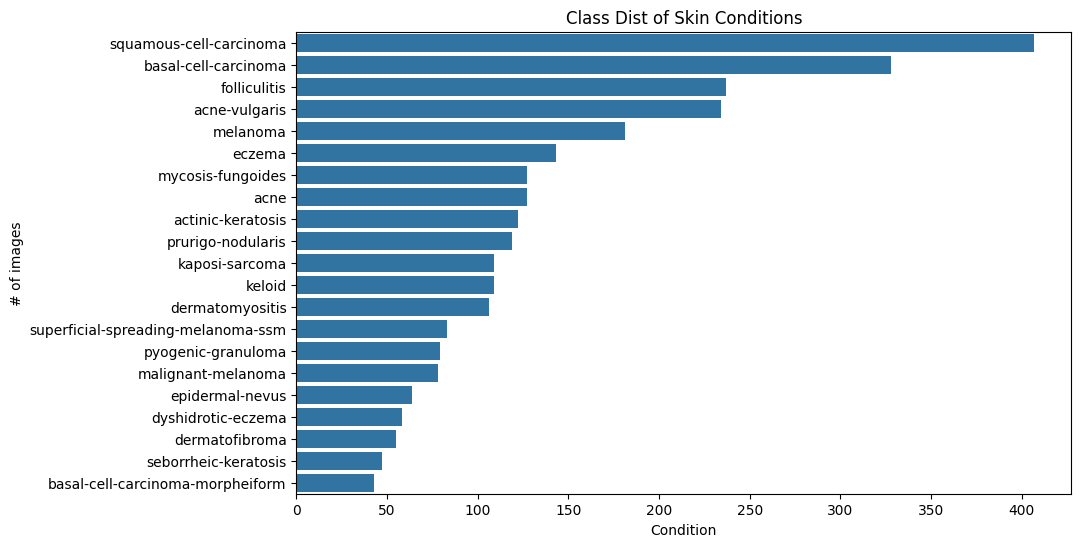

In [83]:
# we do some plots lol
# this is a class distribution plot

plt.figure(figsize = (10,6))
sns.countplot(y = 'label', data = train_df, order = train_df['label'].value_counts().index)
plt.title('Class Dist of Skin Conditions')
plt.xlabel('Condition')
plt.ylabel('# of images')
plt.show()


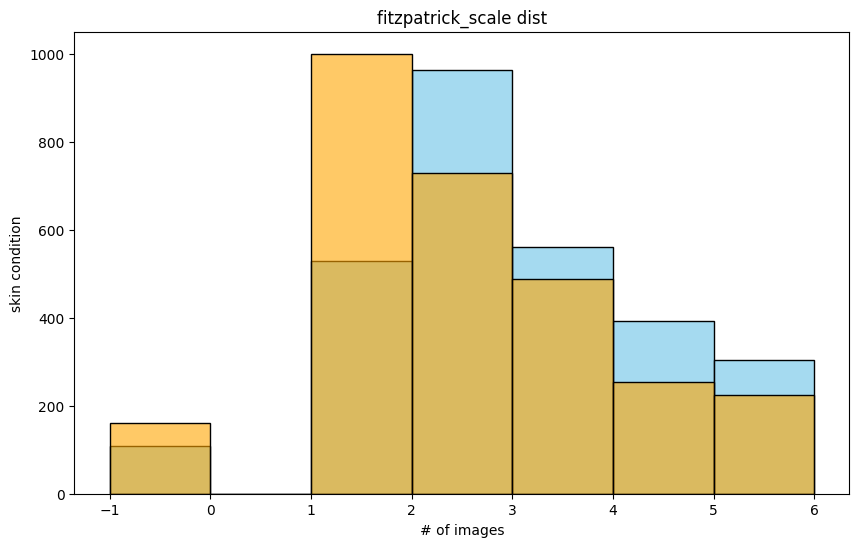

In [84]:
# ofc we need to check skintone distribution 
plt.figure(figsize = (10,6))
sns.histplot(train_df['fitzpatrick_scale'], bins=7, kde=False, color='skyblue', label='Self-reported')
sns.histplot(train_df['fitzpatrick_centaur'], bins=7, kde=False, color='orange', alpha=0.6, label='Centaur Assigned')
plt.title('fitzpatrick_scale dist')
plt.xlabel('# of images')
plt.ylabel('skin condition')
plt.show()


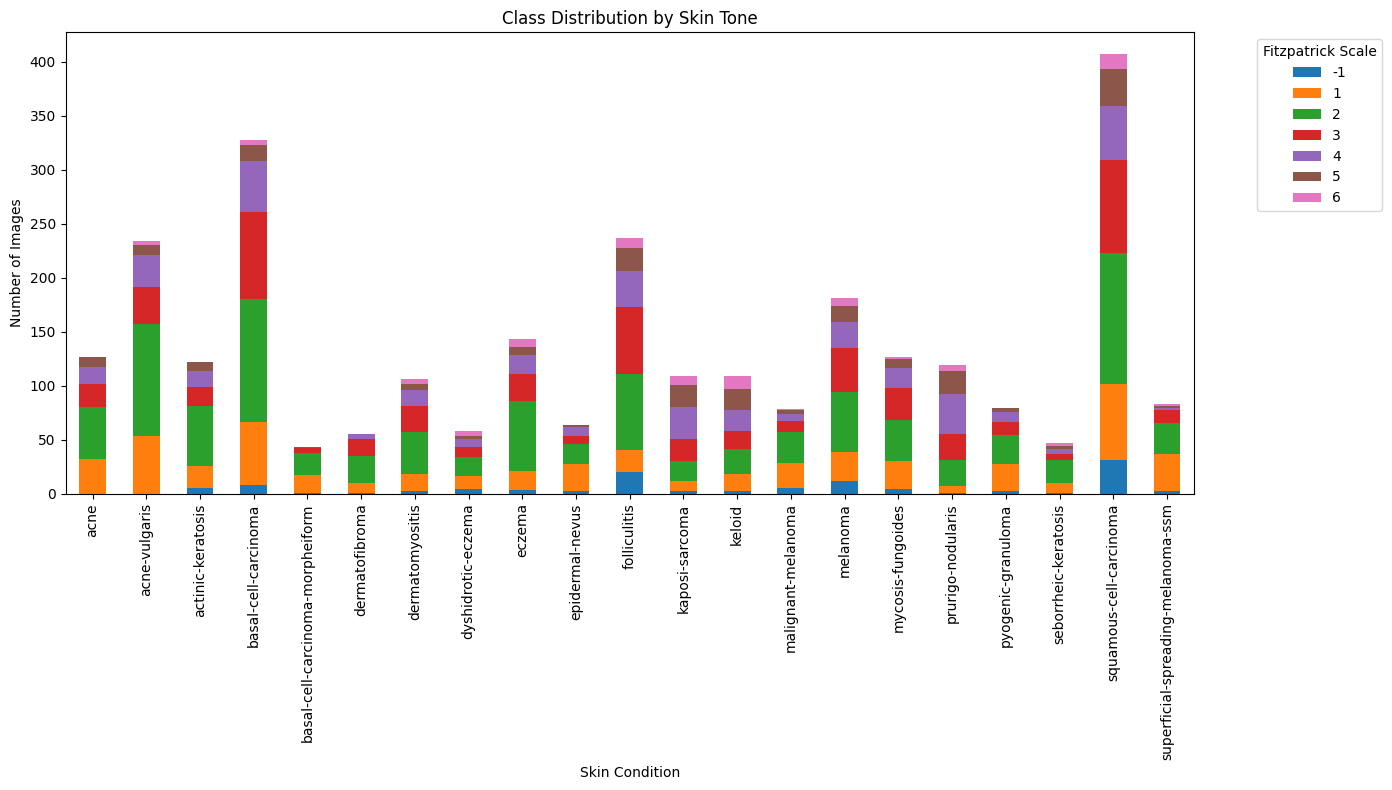

In [85]:
# Class dist by skin tone
pivot_table = pd.pivot_table(train_df, index='label', columns='fitzpatrick_scale', values='md5hash', aggfunc='count', fill_value=0)
pivot_table.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Class Distribution by Skin Tone')
plt.xlabel('Skin Condition')
plt.ylabel('Number of Images')
plt.legend(title='Fitzpatrick Scale', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


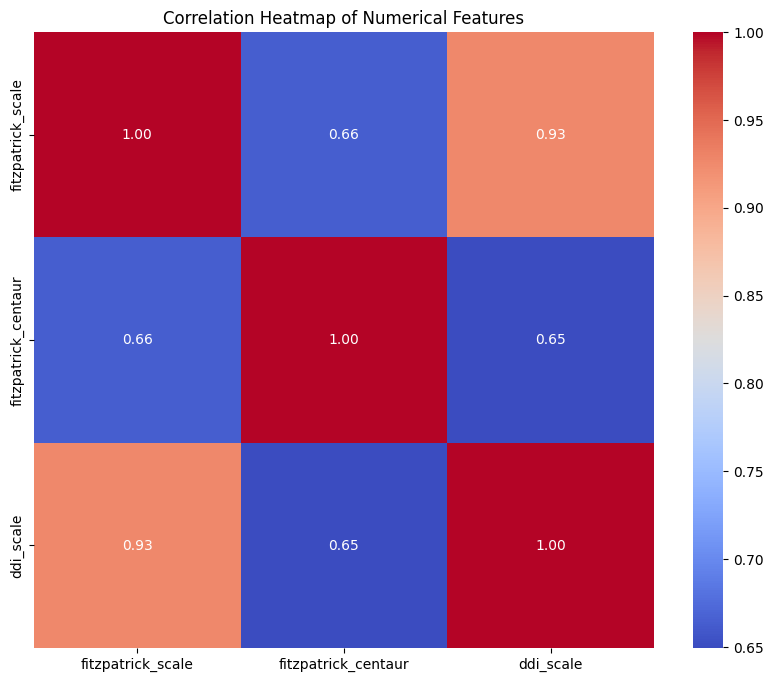

In [86]:
plt.figure(figsize=(10, 8))
corr = train_df[['fitzpatrick_scale', 'fitzpatrick_centaur', 'ddi_scale']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()



## datagens for now aka Image Data Generator

In [27]:
''' my favporite part... DATAGEN TIME!!!'''
# resize to EfnetB2 input size whohc is EfficientNetB2 - (260, 260, 3)
target_size = (260, 260)

# train datagen yippee
datagen = ImageDataGenerator(
    # we have to use efficient net preprocessing lib to be consistent
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.15,
    rotation_range = 30,
    shear_range=0.2,
    zoom_range=0.2,
    # we may not need this if we use efficient net since we have to resize anyway
    # rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True,
    brightness_range=[0.7, 1.2],
    height_shift_range = 0.1,
    width_shift_range = 0.1
)

# flow the data into the datagens
train_data = datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = "train/",
    x_col = "file_path",
    y_col = "encoded_label",
    target_size = target_size,
    batch_size = 32,
    class_mode = "categorical",
    subset = "training",
    shuffle = True,
    seed = 42
)

val_data = datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = "train/",
    x_col = "file_path",
    y_col = "encoded_label",
    target_size = target_size,
    batch_size = 32,
    class_mode = "categorical",
    subset = "validation",
    shuffle = True,
    seed=42
)
# force correct mapping yawn
correct_class_indices = {str(i): i for i in range(len(sorted_labels))}
train_data.class_indices = correct_class_indices

print("\n✅ Final Class Mapping from ImageDataGenerator:", train_data.class_indices)

Found 2428 validated image filenames belonging to 21 classes.
Found 428 validated image filenames belonging to 21 classes.

✅ Final Class Mapping from ImageDataGenerator: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, '11': 11, '12': 12, '13': 13, '14': 14, '15': 15, '16': 16, '17': 17, '18': 18, '19': 19, '20': 20}


## Get Class Weights

In [30]:
train_classes = train_data.classes
cw = class_weight.compute_class_weight(
    # we need it balanced duh lol
    class_weight="balanced",
    classes=np.unique(train_classes),
    y=train_classes
)
class_weights = dict(enumerate(cw))

print("Class Weights:", class_weights)


Class Weights: {0: np.float64(1.080551846906987), 1: np.float64(0.5585461237635151), 2: np.float64(0.5898931000971818), 3: np.float64(1.2299898682877406), 4: np.float64(1.3138528138528138), 5: np.float64(1.8648233486943164), 6: np.float64(0.692329626461363), 7: np.float64(1.0231774125579436), 8: np.float64(1.1447430457331447), 9: np.float64(1.6517006802721088), 10: np.float64(3.0426065162907268), 11: np.float64(0.3461648132306815), 12: np.float64(1.167869167869168), 13: np.float64(1.6284372904091213), 14: np.float64(0.40854787144539795), 15: np.float64(3.2116402116402116), 16: np.float64(2.4087301587301586), 17: np.float64(1.2170426065162907), 18: np.float64(2.2670401493930905), 19: np.float64(1.014202172096909), 20: np.float64(2.1410934744268078)}


## Get/define focal loss
this step was added after the validation was so low yikes

In [89]:
'''
this was taken and inspired by a github notebook I found
using focal loss and label smoothing

for the source look at links below

import tensorflow.keras.backend as K
import tensorflow as tf

def categorical_focal_loss_with_label_smoothing(gamma=2.0, alpha=0.25, ls=0.1, classes=num_classes):
    """
    Implementation of Focal Loss with Label Smoothing for Multi-class Classification.
    
    Formula:
        loss = -alpha * ((1 - p) ^ gamma) * log(p)
        y_ls = (1 - α) * y_hot + α / classes
        
    Parameters:
        alpha -- weight factor for balancing classes
        gamma -- focusing parameter for adjusting loss impact
        ls    -- label smoothing parameter
        classes -- Number of classes in dataset
    """
    def loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=int(classes))
        y_pred_ls = (1 - ls) * y_pred + ls / classes
        y_pred_ls = K.clip(y_pred_ls, epsilon, 1.0 - epsilon)
        cross_entropy = -y_true_one_hot * K.log(y_pred_ls)
        weight = alpha * y_true_one_hot * K.pow((1 - y_pred_ls), gamma)
        loss_val = weight * cross_entropy
        return K.sum(loss_val, axis=1)
    return loss

# check out https://se.mathworks.com/help/vision/ref/nnet.cnn.layer.focallosslayer.html
# https://github.com/jimitshah77/plant-pathology/blob/master/bilinear-efficientnet-focal-loss-label-smoothing.ipynb
'''


'\nthis was taken and inspired by a github notebook I found\nusing focal loss and label smoothing\n\nfor the source look at links below\n\nimport tensorflow.keras.backend as K\nimport tensorflow as tf\n\ndef categorical_focal_loss_with_label_smoothing(gamma=2.0, alpha=0.25, ls=0.1, classes=num_classes):\n    """\n    Implementation of Focal Loss with Label Smoothing for Multi-class Classification.\n    \n    Formula:\n        loss = -alpha * ((1 - p) ^ gamma) * log(p)\n        y_ls = (1 - α) * y_hot + α / classes\n        \n    Parameters:\n        alpha -- weight factor for balancing classes\n        gamma -- focusing parameter for adjusting loss impact\n        ls    -- label smoothing parameter\n        classes -- Number of classes in dataset\n    """\n    def loss(y_true, y_pred):\n        epsilon = K.epsilon()\n        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=int(classes))\n        y_pred_ls = (1 - ls) * y_pred + ls / classes\n        y_pred_ls = K.clip(y_pred_

## Model Building

now we begin model build which will begin by using frozen efficient net layers then move onto
a second training phase after unfreezing some layers

Followiong this, we will fine tune afterwards 

In [31]:
base_model = EfficientNetB2(
    include_top=False,
    weights="imagenet",
    input_shape=(260, 260, 3)
)
# make trianable false for now
base_model.trainable = False


2025-02-19 03:12:29.351859: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [35]:
# add a custom layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(sorted_labels), activation="softmax")(x)

# make/define the model
model = models.Model(inputs=base_model.input, outputs=outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 260, 260,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 260, 260,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 260, 260,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 260, 260,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 261, 261,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 130, 130,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 130, 130,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 130, 130,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 130, 130,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 130, 130,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 130, 130,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 130, 130,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 130, 130,  │        512 │ block1a_se_excit

 Total params: 8,134,670 (31.03 MB)

 Trainable params: 366,101 (1.40 MB)

 Non-trainable params: 7,768,569 (29.63 MB)

In [36]:
from tensorflow.keras.losses import CategoricalCrossentropy

#label smoothing and loss
loss = CategoricalCrossentropy(label_smoothing=0.1)
optimizer = optimizers.Adam(learning_rate=0.0003)

model.compile(optimizer=optimizer, 
              loss=loss, 
              metrics=['accuracy']
             )


In [37]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
]


In [94]:
'''
added focus loss idk the validation was so low
'''
# Now train the model without passing the class_weight parameter:
history = model.fit(
    train_data,
    epochs=50,
    validation_data=val_data,
    callbacks=callbacks
)

'''
IMPORTSNT i havent run thhis cell so the metric below are NOT 
accurate to this model
'''

/home/jovyan/AJL/myenv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 71s 806ms/step - accuracy: 0.1381 - loss: 3.3890 - val_accuracy: 0.2617 - val_loss: 2.9797 - learning_rate: 3.0000e-04
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 58s 755ms/step - accuracy: 0.2889 - loss: 2.9621 - val_accuracy: 0.3411 - val_loss: 2.7793 - learning_rate: 3.0000e-04
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 750ms/step - accuracy: 0.3525 - loss: 2.7565 - val_accuracy: 0.3575 - val_loss: 2.7116 - learning_rate: 3.0000e-04
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 750ms/step - accuracy: 0.3700 - loss: 2.6785 - val_accuracy: 0.4042 - val_loss: 2.5815 - learning_rate: 3.0000e-04
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 749ms/step - accuracy: 0.4128 - loss: 2.5568 - val_accuracy: 0.3808 - val_loss: 2.5302 - learning_rate: 3.0000e-04
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 58s 757ms/step - accuracy: 0.4365 - loss: 2.4565 - val_accuracy: 0.4206 - val_loss: 2.4862 - learning_rate: 3.0000e-04
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 752ms/step - acc

In [95]:
# unfreeze some EfficientNetB2 layers
base_model.trainable = True

'''
we can do this but idk if we want to try running it first or not
# Unfreeze the last 50 layers
for layer in base_model.layers[:-50]:
    layer.trainable = False
'''

# compile again w/ smaller rate
model.compile(
    optimizer = optimizers.Adam(learning_rate = 0.00001),
    loss = loss,
    metrics = ["accuracy"]
)


Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.5112 - loss: 2.2735 - val_accuracy: 0.5234 - val_loss: 2.1215 - learning_rate: 1.0000e-05
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 76s 992ms/step - accuracy: 0.5380 - loss: 2.1495 - val_accuracy: 0.5327 - val_loss: 2.1525 - learning_rate: 1.0000e-05
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 76s 994ms/step - accuracy: 0.5772 - loss: 2.0700 - val_accuracy: 0.5047 - val_loss: 2.2067 - learning_rate: 1.0000e-05
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 76s 998ms/step - accuracy: 0.5907 - loss: 2.0150 - val_accuracy: 0.4977 - val_loss: 2.1910 - learning_rate: 1.0000e-05
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 76s 996ms/step - accuracy: 0.5811 - loss: 1.9626 - val_accuracy: 0.4836 - val_loss: 2.1926 - learning_rate: 1.0000e-05
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 76s 995ms/step - accuracy: 0.6246 - loss: 1.9306 - val_accuracy: 0.4907 - val_loss: 2.1837 - learning_rate: 1.0000e-05
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 76s 993ms/step - accura

In [ ]:
# train again for fine-tuning
history = model.fit(
    train_data,
    # we can add more or less
    epochs = 20,
    validation_data = val_data,
    callbacks = callbacks
)

In [38]:
import matplotlib.pyplot as plt

# Extract loss and accuracy from history
def plot_training(history, title="Training Performance"):
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

# Plot initial training results
plot_training(history, title="Initial Training")

# Plot fine-tuning results
plot_training(history_finetune, title="Fine-Tuning Training")


NameError: name 'history' is not defined